# **Preprocessing**

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open 
import glob 
import os

import unicodedata
import string

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

In [2]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                    if unicodedata.category(c) != 'Mn' and c in all_letters)

print(unicode_to_ascii("Ślusàrski"))

Slusarski


In [3]:
print(glob.glob('../data/*.txt'))

['../data/Irish.txt', '../data/French.txt', '../data/Chinese.txt', '../data/Czech.txt', '../data/Italian.txt', '../data/Arabic.txt', '../data/Greek.txt', '../data/English.txt', '../data/Scottish.txt', '../data/Dutch.txt', '../data/Russian.txt', '../data/Spanish.txt', '../data/Korean.txt', '../data/Polish.txt', '../data/German.txt', '../data/Portuguese.txt', '../data/Japanese.txt', '../data/Vietnamese.txt']


In [4]:
category_lines = {}
all_categories = []

def process_data(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicode_to_ascii(line) for line in lines]

for filename in glob.glob('../data/*.txt'):
  language = filename.split('/')[-1][:-4]
  all_categories.append(language)
  category_lines[language] = process_data(filename)

In [5]:
n_categories = len(all_categories)

In [6]:
len(category_lines['Russian'])

9408

In [7]:
import random

russian_proccessed = []
english_proccessed = []

for _ in range (2500):
  russian_proccessed.append(random.choice(category_lines['Russian']))
  english_proccessed.append(random.choice(category_lines['English']))

print(len(russian_proccessed), len(english_proccessed))

print(russian_proccessed[:10])

2500 2500
['Balasoglo', 'Zhiznyakov', 'Agdarov', 'Agudov', 'Abrikosov', 'Serednyakov', 'Haneev', 'Kalaganov', 'Djumaniyazov', 'Muladjanov']


In [8]:
category_lines['Russian'] = russian_proccessed
category_lines['English'] = english_proccessed

print([len(i) for i in category_lines.values()])

[232, 277, 268, 519, 709, 2000, 203, 2500, 100, 297, 2500, 298, 94, 139, 724, 74, 991, 73]


In [9]:
for key, item in category_lines.items():
  print(key, len(item))

Irish 232
French 277
Chinese 268
Czech 519
Italian 709
Arabic 2000
Greek 203
English 2500
Scottish 100
Dutch 297
Russian 2500
Spanish 298
Korean 94
Polish 139
German 724
Portuguese 74
Japanese 991
Vietnamese 73


# **TENSORS**

In [10]:
import torch
import torch.nn.functional as F

In [11]:
def letter_to_index(letter):
  return all_letters.find(letter)

def letter_to_tensor(letter):
  one_hot = torch.zeros(1, n_letters)
  one_hot[0][letter_to_index(letter)] = 1
  return one_hot

print(letter_to_tensor('o'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


In [12]:
def line_to_tensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for ind, letter in enumerate(line):
    tensor[ind] = letter_to_tensor(letter)
  return tensor

print(line_to_tensor('hi').shape)

torch.Size([2, 1, 56])


In [13]:
def category_from_output(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()

  return all_categories[category_i], category_i


In [14]:
from sklearn.model_selection import train_test_split

train_data = {}
test_data = {}
val_data = {}

for key, value in category_lines.items():
  x_train, x_test, y_train, y_test = train_test_split(value, [key]*len(value), test_size=0.1)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)
  train_data[key] = x_train
  test_data[key] = x_test
  val_data[key] = x_val
  

In [ ]:
for i in range(10):
  print(all_categories[i], len(train_data[all_categories[i]]))
  print(len(test_data[all_categories[i]]))

Greek 154
21
Korean 71
10
Vietnamese 55
8
Irish 176
24
Spanish 227
30
French 211
28
Russian 1912
250
English 1912
250
German 553
73
Polish 106
14


## MODEL

In [15]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(1)

  def forward(self, input, hidden):
    emb = torch.cat((input, hidden), 1)
    hidden_state = self.i2h(emb)
    output = self.i2o(emb)
    output = self.softmax(output)

    return output, hidden_state
  
  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)


In [16]:
criterion = nn.NLLLoss()

def train_rnn(category_tensor, line_tensor, learning_rate):
  hidden = rnn.init_hidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn.forward(line_tensor[i], hidden)
  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)
  
  return output, loss.item()

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
 


def random_choice(l):
  return l[random.randint(0, len(l)-1)]

def randomTrainingExample(data):
  category = random_choice(all_categories)
  line = random_choice(data[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = line_to_tensor(line)
  return category, line, category_tensor, line_tensor


train_y = [] 
train_x = []

for key, value in train_data.items():
  train_x = train_x + value
  train_y = train_y + [key]*len(value)

def randomTrainingExample_fixed():
  n = random.randint(0, len(train_y)-1)
  category = train_y[n]
  line = train_x[n]
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = line_to_tensor(line)
  return category, line, category_tensor, line_tensor

def train_rnn(category_tensor, line_tensor, learning_rate):
  hidden = rnn.init_hidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn.forward(line_tensor[i], hidden)
  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)
  
  return output, loss.item()

def evaluate_rnn(line_tensor):
  hidden = rnn.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn.forward(line_tensor[i], hidden)

  return output

0.001 7500 0.05 2.8432183265686035 Maloney Scottish English
0.001 15000 0.1 2.733290910720825 Trujillo German Spanish
0.001 22500 0.15 2.4742345809936523 Assaf Chinese Arabic
0.001 30000 0.2 1.9582675695419312 Tableriou Arabic Greek
0.001 37500 0.25 2.8095650672912598 Loskot Irish Czech
0.001 45000 0.3 1.4304931163787842 Romeijnsen French Dutch
0.001 52500 0.35 1.376967430114746 Chou Arabic Chinese
0.001 60000 0.4 0.3421251177787781 Kusuhara Chinese Japanese
0.001 67500 0.45 0.5827216506004333 Yoo Polish Korean
0.001 75000 0.5 1.4526617527008057 Rorris Spanish Greek
0.001 82500 0.55 1.5167384147644043 Walther Japanese German
0.001 90000 0.6 1.974429965019226 Baik French Korean
0.001 97500 0.65 0.9746606349945068 Vo Vietnamese Vietnamese
0.001 105000 0.7 1.2037605047225952 Freitas Polish Portuguese
0.001 112500 0.75 1.3505358695983887 Sai Vietnamese Vietnamese
0.001 120000 0.8 2.11460018157959 Grec Portuguese Spanish
0.001 127500 0.85 0.5007977485656738 Sakellariou Italian Greek
0.001 1

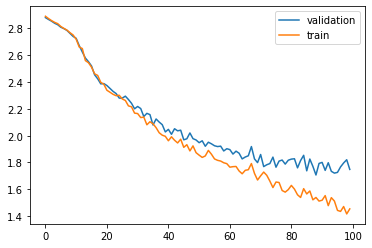

accuracy train:  0.5481


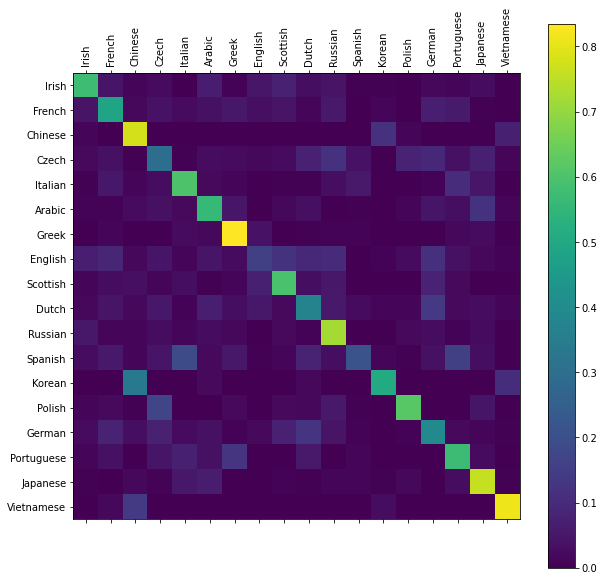

accuracy test:  0.4382


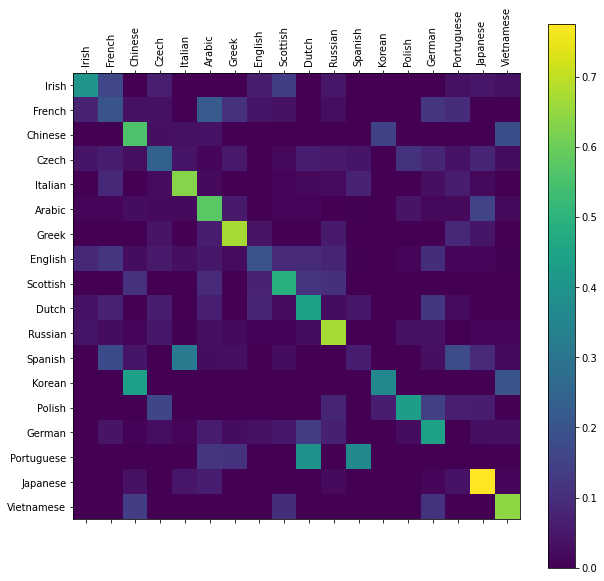

0.0025 7500 0.05 2.7378530502319336 Watkins Greek English
0.0025 15000 0.1 1.4568268060684204 Niu Russian Chinese
0.0025 22500 0.15 1.4094922542572021 Lian French Chinese
0.0025 30000 0.2 2.6233296394348145 Medeiros Arabic Portuguese
0.0025 37500 0.25 1.6238203048706055 Hamilton Russian Scottish
0.0025 45000 0.3 2.788825035095215 O'Keefe Scottish Irish
0.0025 52500 0.35 0.8335683941841125 Zhong Vietnamese Chinese
0.0025 60000 0.4 1.8001313209533691 Sai Irish Vietnamese
0.0025 67500 0.45 0.1467762142419815 Mokhnachev Irish Russian
0.0025 75000 0.5 1.1588261127471924 See Spanish Chinese
0.0025 82500 0.55 0.2886512577533722 Kozlow Chinese Polish
0.0025 90000 0.6 3.96758770942688 Blanc Chinese French
0.0025 97500 0.65 2.131181240081787 Milner Italian English
0.0025 105000 0.7 1.3220932483673096 Broughton Polish English
0.0025 112500 0.75 0.9353201985359192 Blanchet Vietnamese French
0.0025 120000 0.8 1.2502533197402954 Nowak Dutch Polish
0.0025 127500 0.85 0.5269720554351807 Chu Spanish Vi

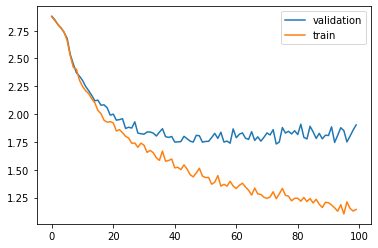

accuracy train:  0.6395


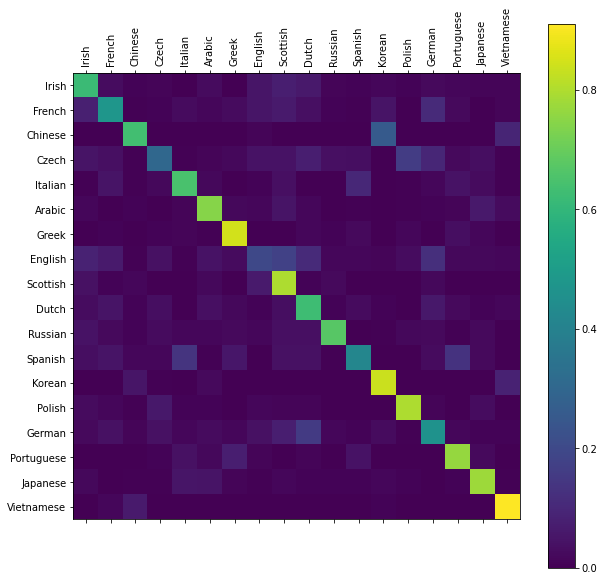

accuracy test:  0.4751


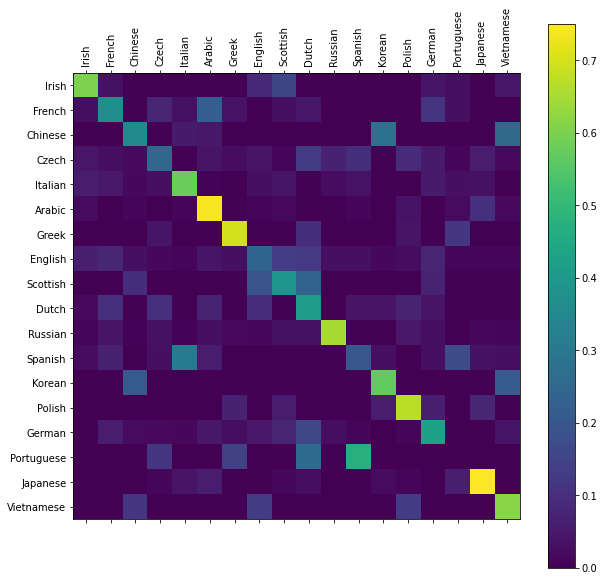

0.005 7500 0.05 3.931469440460205 Gravari Japanese Greek
0.005 15000 0.1 3.4126601219177246 Roig Dutch Spanish
0.005 22500 0.15 2.6723222732543945 Shunsen Chinese Japanese
0.005 30000 0.2 0.9294172525405884 Fernandes German Portuguese
0.005 37500 0.25 1.8148099184036255 Harb Japanese Arabic
0.005 45000 0.3 1.4587202072143555 Lim Chinese Korean
0.005 52500 0.35 1.2923014163970947 Dounias Portuguese Greek
0.005 60000 0.4 0.6770929098129272 Xydis Vietnamese Greek
0.005 67500 0.45 0.045037075877189636 Meeuwessen Japanese Dutch
0.005 75000 0.5 0.590207576751709 Rorris Czech Greek
0.005 82500 0.55 0.08506988734006882 Julidov French Russian
0.005 90000 0.6 0.9920324683189392 Arechavaleta Japanese Spanish
0.005 97500 0.65 2.7010254859924316 Tos Spanish Spanish
0.005 105000 0.7 2.409956932067871 Wirt Korean German
0.005 112500 0.75 0.4397987425327301 Shammas Korean Arabic
0.005 120000 0.8 3.412975311279297 Tremble Arabic French
0.005 127500 0.85 3.419994831085205 Mulder French Dutch
0.005 13500

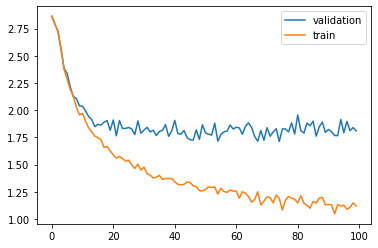

accuracy train:  0.6437


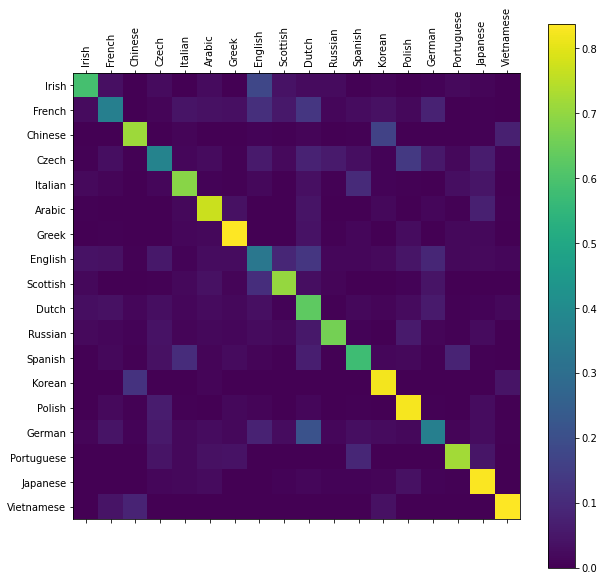

accuracy test:  0.4559


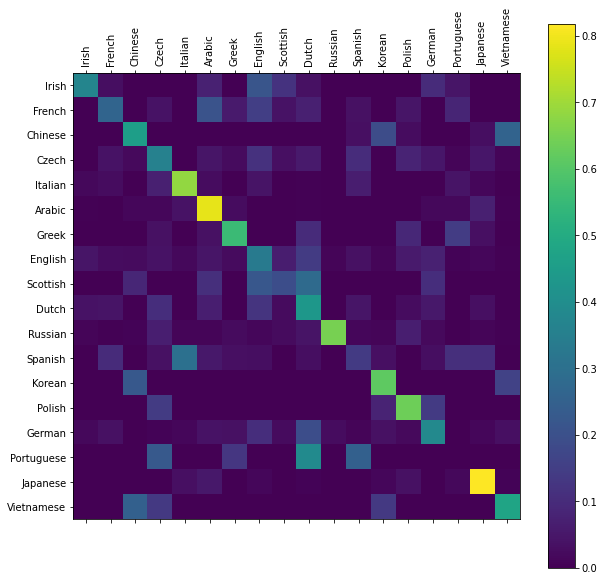

In [34]:

n_hidden = 128
learning_rates = [0.001, 0.0025, 0.005]

for learning_rate in learning_rates:
  rnn = RNN(n_letters, n_hidden, n_categories)

  n_iters = 150000
  print_every = 7500
  plot_every = 1500

  current_loss_train = 0
  all_losses_train = []
  current_loss_val = 0
  all_losses_val = []

  for iter in range(1, n_iters + 1):
    category_train, line_train, category_tensor_train, line_tensor_train = randomTrainingExample(train_data)
    output_train, loss_train = train_rnn(category_tensor_train, line_tensor_train, learning_rate)
    current_loss_train += loss_train

    category_val, line_val, category_tensor_val, line_tensor_val = randomTrainingExample(val_data)
    hidden = rnn.init_hidden()
    for i in range(line_tensor_val.size()[0]):
      output, hidden = rnn.forward(line_tensor_val[i], hidden)
    loss_val = criterion(output, category_tensor_val).item()
    current_loss_val += loss_val

    if iter % print_every == 0:
      guess, guess_i = category_from_output(output)
      print(learning_rate, iter, iter/n_iters, loss_train, line_train, guess, category_train)
  
    if iter % plot_every == 0:
      all_losses_train.append(current_loss_train/plot_every)
      current_loss_train = 0
      all_losses_val.append(current_loss_val/plot_every)
      current_loss_val = 0


  fig, ax = plt.subplots()
  ax.plot(all_losses_val, label='validation')
  ax.plot(all_losses_train, label='train')
  legend = ax.legend(loc='upper right')
  plt.show()
  
  confusion = torch.zeros(n_categories, n_categories)
  
  n_confusion = 10000
  
  pre = 0
  for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(train_data)
    output = evaluate_rnn(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    if category == guess:
        pre +=1
    confusion[category_i][guess_i] += 1
  
  print("accuracy train: ", pre/n_confusion)
  for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot()
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)
  
  ax.set_xticklabels([''] + all_categories, rotation=90)
  ax.set_yticklabels([''] + all_categories)
  
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()
  
  pre = 0
  for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(test_data)
    output = evaluate_rnn(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    if category == guess:
        pre +=1
    confusion[category_i][guess_i] += 1
  
  print("accuracy test: ", pre/n_confusion)
  for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
  
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot()
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)
  
  ax.set_xticklabels([''] + all_categories, rotation=90)
  ax.set_yticklabels([''] + all_categories)
  
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

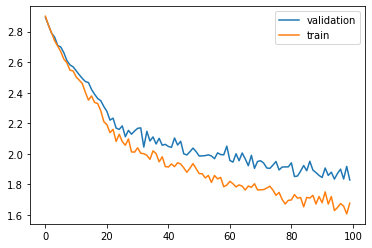

In [ ]:
fig, ax = plt.subplots()
ax.plot(all_losses_val, label='validation')
ax.plot(all_losses_train, label='train')
legend = ax.legend(loc='upper right')
plt.show()

In [ ]:
pre = 0
total = 0
pre_by_lang = []
total_by_lang = []
for key, values in test_data.items():
  temp_pre = 0
  total_by_lang.append(len(values))
  for value in values:
    line_tensor = line_to_tensor(value)
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    if key == guess:
      temp_pre +=1
  pre_by_lang.append(temp_pre)

per_by_lang = {}
for id, (predicted, ground) in enumerate(zip(pre_by_lang, total_by_lang)):
  per_by_lang[all_categories[id]] = predicted/ground

print(pre_by_lang)
print(total_by_lang)
print(per_by_lang)

[8, 56, 49, 138, 11, 24, 23, 2, 14, 5, 16, 181, 12, 10, 72, 7, 2, 9]
[30, 100, 71, 200, 28, 73, 52, 10, 27, 10, 21, 250, 24, 30, 250, 8, 8, 14]
{'Spanish': 0.26666666666666666, 'Japanese': 0.56, 'Italian': 0.6901408450704225, 'Arabic': 0.69, 'French': 0.39285714285714285, 'German': 0.3287671232876712, 'Czech': 0.4423076923076923, 'Scottish': 0.2, 'Chinese': 0.5185185185185185, 'Korean': 0.5, 'Greek': 0.7619047619047619, 'Russian': 0.724, 'Irish': 0.5, 'Dutch': 0.3333333333333333, 'English': 0.288, 'Vietnamese': 0.875, 'Portuguese': 0.25, 'Polish': 0.6428571428571429}


In [ ]:
print(sum(per_by_lang.values())/len(all_categories))

0.45485083088709316


In [ ]:
print(sum(pre_by_lang)/sum(total_by_lang))

0.4125839343446904


In [ ]:
input = letter_to_tensor('A')
hidden = torch.zeros(1, n_hidden)

output, _ = rnn.forward(input, hidden)
print(output)

tensor([[-2.8854, -2.8986, -2.9097, -2.9164, -2.8895, -2.9032, -2.8878, -2.8955,
         -2.8764, -2.8600, -2.9037, -2.8797, -2.8724, -2.8905, -2.8961, -2.9144,
         -2.8829, -2.8666]], grad_fn=<LogSoftmaxBackward>)


### GRU

In [17]:
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRU, self).__init__()

    self.hidden_size = hidden_size
    self.gru = nn.GRU(input_size, hidden_size, 1, dropout=0.2)
    self.softmax = nn.LogSoftmax(2)
    self.i2o = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden):
    output, hidden_state = self.gru(input.view(1, 1, -1), hidden)
    output = self.i2o(output)
    output = self.softmax(output)
    return output, hidden_state
  
  def init_hidden(self):
    return torch.zeros(1, 1, self.hidden_size)

def train_gru(category_tensor, line_tensor, learning_rate):
  hidden = gru.init_hidden()

  gru.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = gru.forward(line_tensor[i], hidden)
  
  loss = criterion(output.view(1, -1), category_tensor)
  loss.backward()

  for p in gru.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

def evaluate_gru(line_tensor):
  hidden = gru.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = gru.forward(line_tensor[i], hidden)

  return output
# input
#hidden = 1, 1, hidden_size
n_hidden = 128
learning_rate = 0.005


0.01 10000 0.1 2.658721446990967 Severins Arabic Dutch
0.01 20000 0.2 2.2940421104431152 Doan Italian Vietnamese
0.01 30000 0.3 0.5714640617370605 Vargas Korean Portuguese
0.01 40000 0.4 0.34903889894485474 Dasios Polish Greek
0.01 50000 0.5 1.9193204641342163 Patril German Czech
0.01 60000 0.6 0.3516289293766022 Rigatos Japanese Greek
0.01 70000 0.7 0.89425128698349 Amersvoort Spanish Dutch
0.01 80000 0.8 4.568899154663086 Peary Italian Czech
0.01 90000 0.9 2.1063976287841797 Lawa Spanish Czech
0.01 100000 1.0 0.8036878108978271 Kolacny Greek Czech


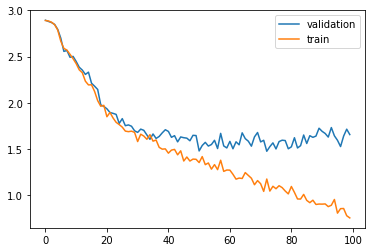

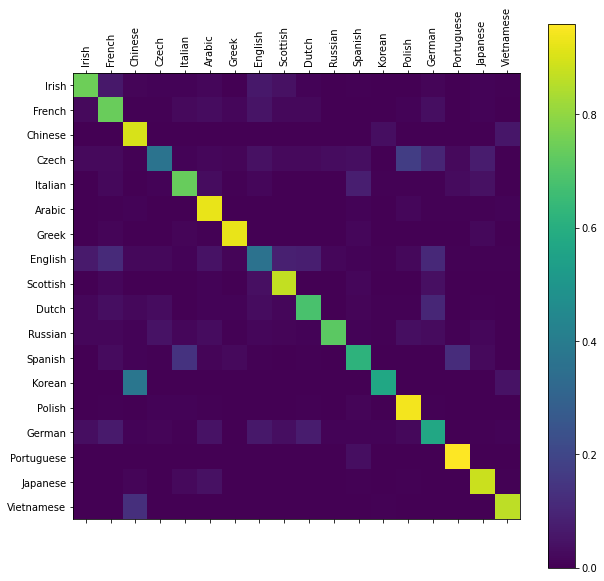

accuracy train:  0.7477
accuracy test:  0.5234


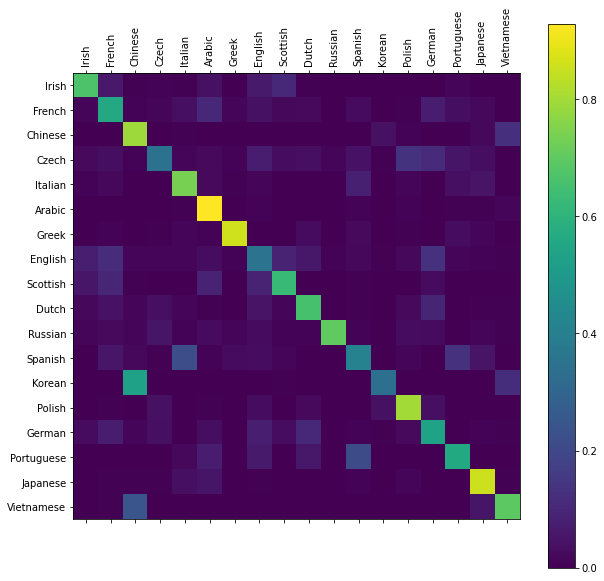

0.02 10000 0.1 2.239060878753662 Delacruz Greek Spanish
0.02 20000 0.2 1.0080194473266602 Miksatkova Irish Czech
0.02 30000 0.3 0.6489090323448181 an English Vietnamese
0.02 40000 0.4 0.6095780730247498 Vescovi Korean Italian
0.02 50000 0.5 0.16063696146011353 Bahar Chinese Arabic
0.02 60000 0.6 0.05988788977265358 Zdunowski Japanese Polish
0.02 70000 0.7 0.7827523350715637 Gaber Vietnamese Arabic
0.02 80000 0.8 0.35154664516448975 Kassis Arabic Arabic
0.02 90000 0.9 2.9195656776428223 You Greek Chinese
0.02 100000 1.0 0.005069497041404247 Abategiovanni English Italian


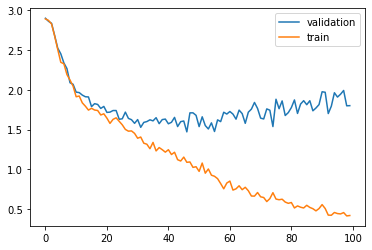

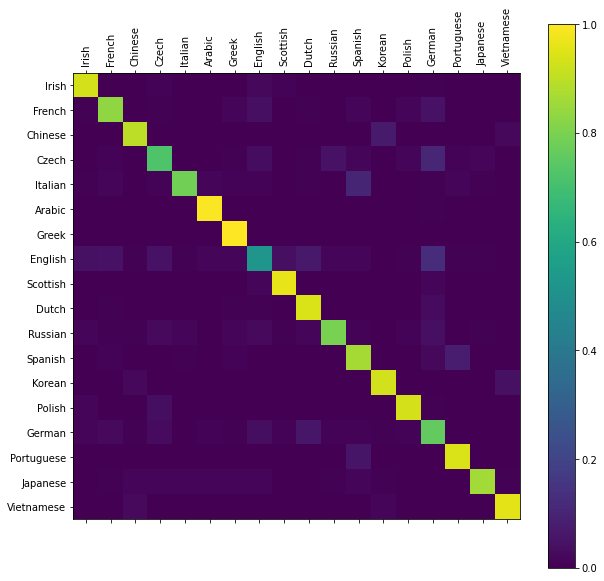

accuracy train:  0.8765
accuracy test:  0.5445


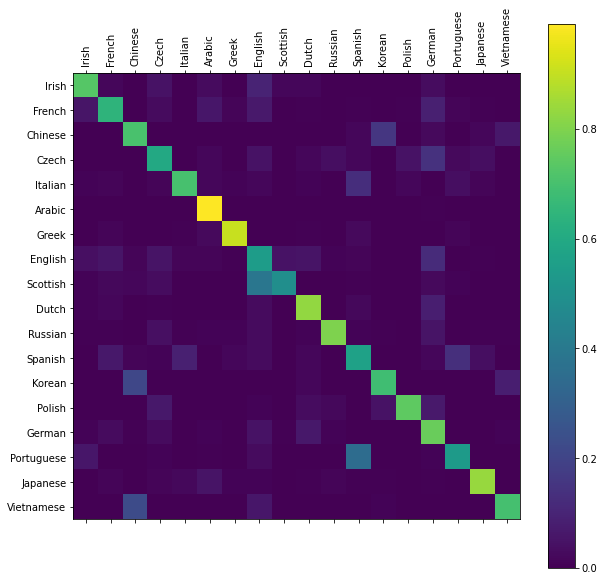

0.025 10000 0.1 1.1811195611953735 Duong Arabic Vietnamese
0.025 20000 0.2 0.025128277018666267 Kosmatka French Polish
0.025 30000 0.3 0.6159873604774475 Weng Portuguese Chinese
0.025 40000 0.4 0.06188783422112465 O'Hare Chinese Irish
0.025 50000 0.5 0.16865970194339752 Romao Arabic Portuguese
0.025 60000 0.6 0.13204289972782135 Faucheux Greek French
0.025 70000 0.7 0.029233846813440323 D'cruz Greek Portuguese
0.025 80000 0.8 0.16697454452514648 Mo Chinese Korean
0.025 90000 0.9 0.01137709990143776 Tao Italian Chinese
0.025 100000 1.0 0.5834608674049377 Agramunt English Spanish


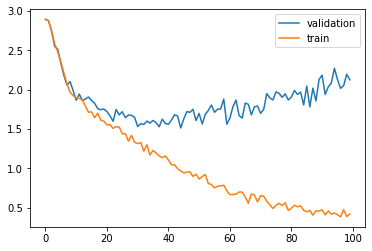

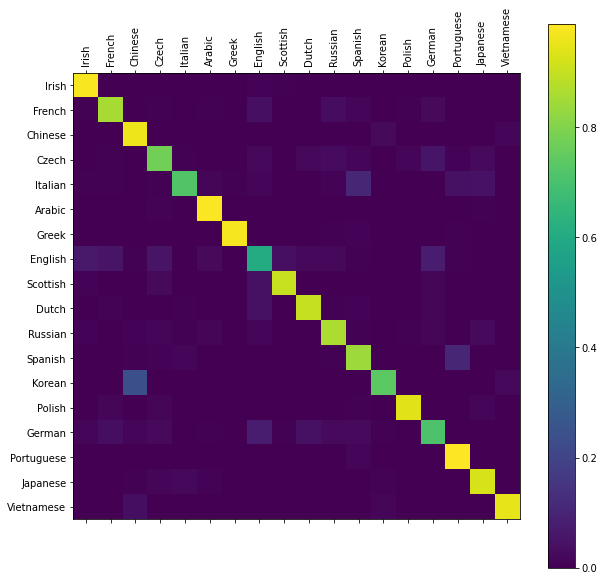

accuracy train:  0.8677
accuracy test:  0.5214


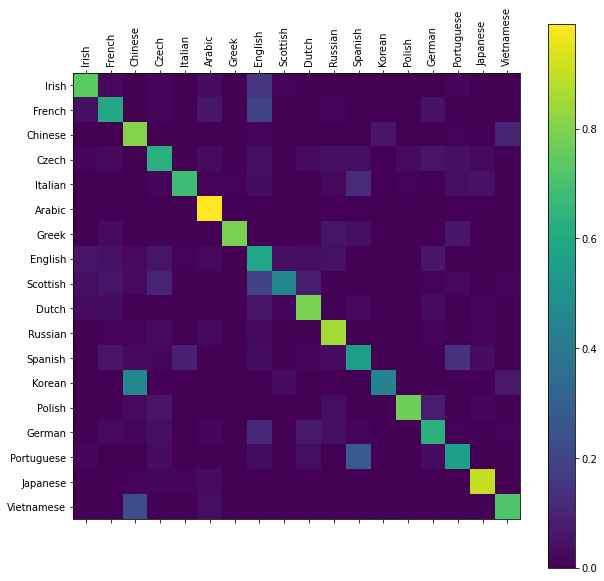

0.03 10000 0.1 2.047912836074829 Sai Irish Vietnamese
0.03 20000 0.2 0.25992828607559204 Son Polish Korean
0.03 30000 0.3 0.2216646522283554 Chin Korean Korean
0.03 40000 0.4 1.4771510362625122 Sleiman Portuguese Arabic
0.03 50000 0.5 0.07123192399740219 Szwarc Chinese Polish
0.03 60000 0.6 0.07628500461578369 Abalov Spanish Russian
0.03 70000 0.7 0.07340940833091736 Kapsimalles Vietnamese Greek
0.03 80000 0.8 0.07319847494363785 Zawisza English Polish
0.03 90000 0.9 0.447780579328537 Villanueva Chinese Spanish
0.03 100000 1.0 0.5867577195167542 Mochan English Irish


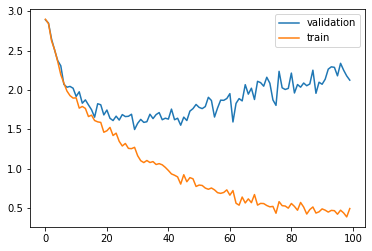

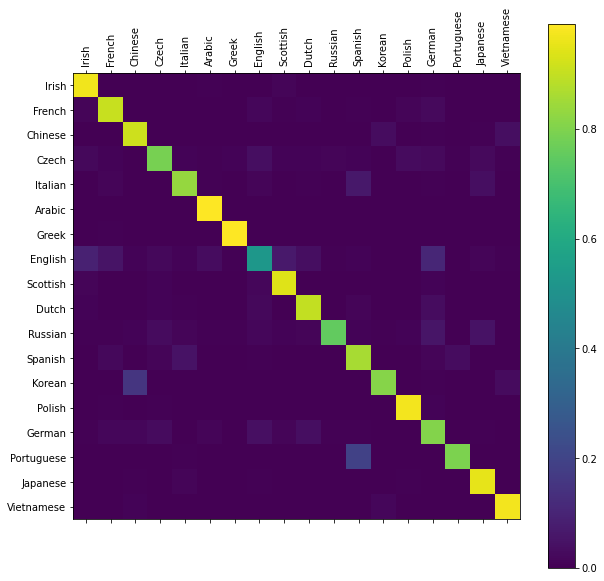

accuracy train:  0.8745
accuracy test:  0.5226


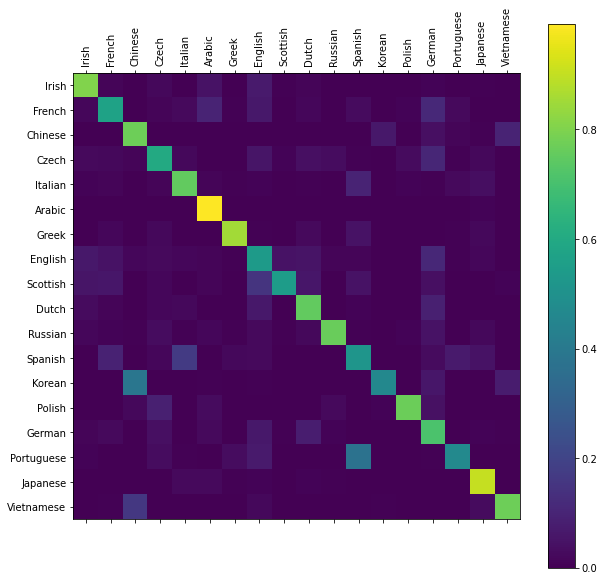

0.05 10000 0.1 2.42940616607666 Voigt Chinese German
0.05 20000 0.2 1.6274845600128174 Kriz French Czech
0.05 30000 0.3 4.178038597106934 Masin Portuguese Italian
0.05 40000 0.4 0.04345554858446121 Ryusaki Irish Japanese
0.05 50000 0.5 2.185746669769287 Buren Dutch Dutch
0.05 60000 0.6 0.006791010964661837 Doan Greek Vietnamese
0.05 70000 0.7 1.277772307395935 Lim Portuguese Korean
0.05 80000 0.8 7.776772499084473 Michel Spanish German
0.05 90000 0.9 2.2309982776641846 Saionji Russian Japanese
0.05 100000 1.0 3.402050495147705 Duarte Italian Spanish


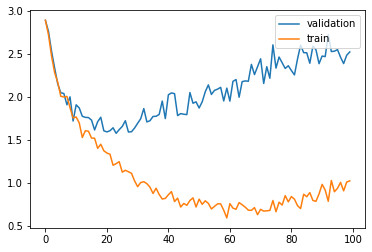

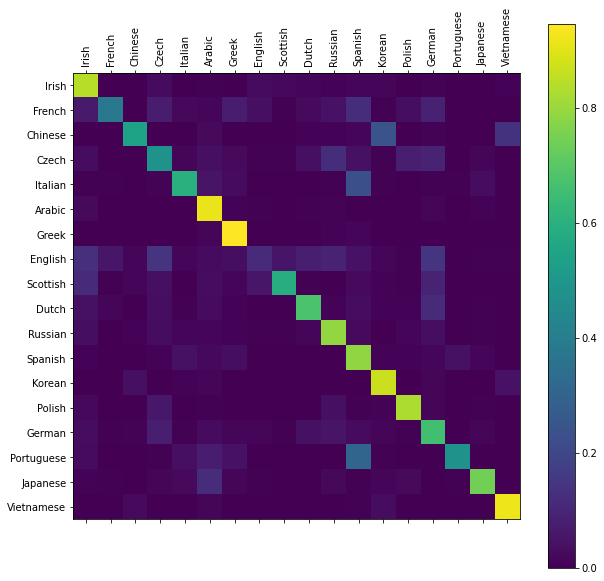

accuracy train:  0.6755
accuracy test:  0.4696


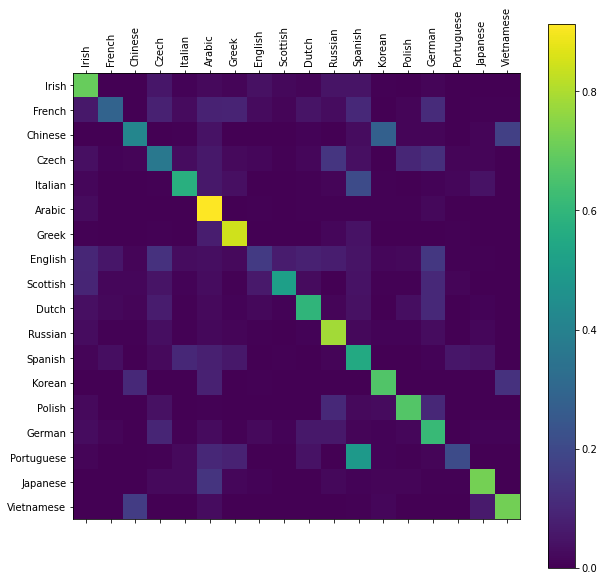

In [32]:
n_hidden = 128
learning_rates = [0.01, 0.02, 0.025, 0.03, 0.05]

for learning_rate in learning_rates:
  gru = GRU(n_letters, n_hidden, n_categories)

  n_iters = 100000
  print_every = 10000
  plot_every = 1000

  current_loss_train = 0
  all_losses_train = []
  current_loss_val = 0
  all_losses_val = []

  for iter in range(1, n_iters + 1):
    category_train, line_train, category_tensor_train, line_tensor_train = randomTrainingExample(train_data)
    output_train, loss_train = train_gru(category_tensor_train, line_tensor_train, learning_rate)
    current_loss_train += loss_train

    category_val, line_val, category_tensor_val, line_tensor_val = randomTrainingExample(val_data)
    hidden = gru.init_hidden()
    for i in range(line_tensor_val.size()[0]):
      output, hidden = gru.forward(line_tensor_val[i], hidden)
    loss_val = criterion(output.view(1, -1), category_tensor_val).item()
    current_loss_val += loss_val

    if iter % print_every == 0:
      guess, guess_i = category_from_output(output)
      print(learning_rate, iter, iter/n_iters, loss_train, line_train, guess, category_train)
  
    if iter % plot_every == 0:
      all_losses_train.append(current_loss_train/plot_every)
      current_loss_train = 0
      all_losses_val.append(current_loss_val/plot_every)
      current_loss_val = 0


  fig, ax = plt.subplots()
  ax.plot(all_losses_val, label='validation')
  ax.plot(all_losses_train, label='train')
  legend = ax.legend(loc='upper right')
  plt.show()
  confusion = torch.zeros(n_categories, n_categories)

  n_confusion = 10000

  for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(train_data)
    output = evaluate_gru(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

  for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot()
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)

  ax.set_xticklabels([''] + all_categories, rotation=90)
  ax.set_yticklabels([''] + all_categories)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

  pre = 0
  for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(train_data)
    output = evaluate_gru(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    if category == guess:
      pre +=1
    confusion[category_i][guess_i] += 1
  print("accuracy train: ", pre/n_confusion)

  pre = 0
  for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(test_data)
    output = evaluate_gru(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    if category == guess:
      pre +=1
    confusion[category_i][guess_i] += 1

  print("accuracy test: ", pre/n_confusion)
  for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot()
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)

  ax.set_xticklabels([''] + all_categories, rotation=90)
  ax.set_yticklabels([''] + all_categories)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

In [28]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM, self).__init__()

    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size)
    self.softmax = nn.LogSoftmax(2)
    self.i2o = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden, cell):
    output, (hidden_state, cell_state) = self.lstm(input.view(1, 1, -1), (hidden, cell))
    output = self.i2o(output)
    output = self.softmax(output)
    return output, (hidden_state, cell_state)
  
  def init_hidden(self):
    return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

def train_lstm(category_tensor, line_tensor, learning_rate):
  (hidden, cell) = lstm.init_hidden()

  lstm.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, (hidden, cell) = lstm.forward(line_tensor[i], hidden, cell)
  
  loss = criterion(output.view(1, -1), category_tensor)
  loss.backward()

  for p in lstm.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

def evaluate_lstm(line_tensor):
  (hidden, cell) = lstm.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, (hidden, cell) = lstm.forward(line_tensor[i], hidden, cell)

  return output



0.01 10000 0.1 2.6503264904022217 Ferro Polish Portuguese
0.01 20000 0.2 0.8169732689857483 Polites German Greek
0.01 30000 0.3 2.2119393348693848 Brant Irish German
0.01 40000 0.4 1.4246549606323242 Mccallum Russian Scottish
0.01 50000 0.5 0.5606370568275452 Sitko Japanese Polish
0.01 60000 0.6 4.748076438903809 Desantis Japanese Italian
0.01 70000 0.7 0.1235957071185112 Rooiakkers Japanese Dutch
0.01 80000 0.8 0.7173140645027161 Rhee Italian Korean
0.01 90000 0.9 0.12558798491954803 Madden Irish Irish
0.01 100000 1.0 1.3960051536560059 Cormac French Irish


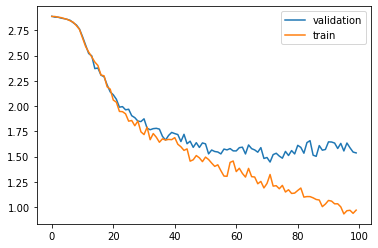

accuracy train:  0.6839


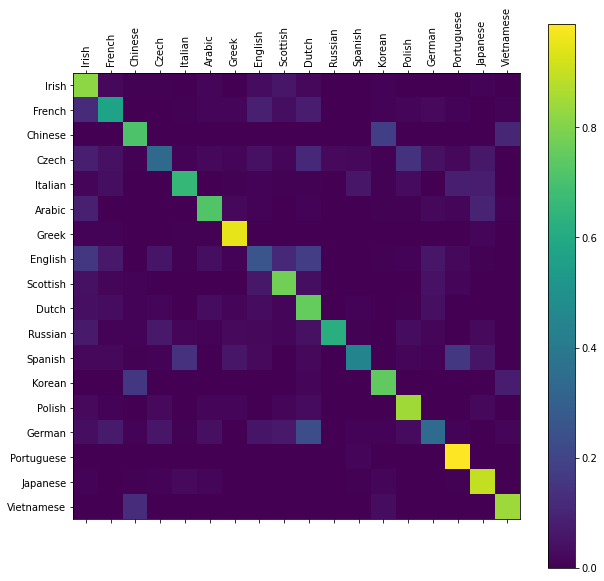

accuracy test:  0.5001


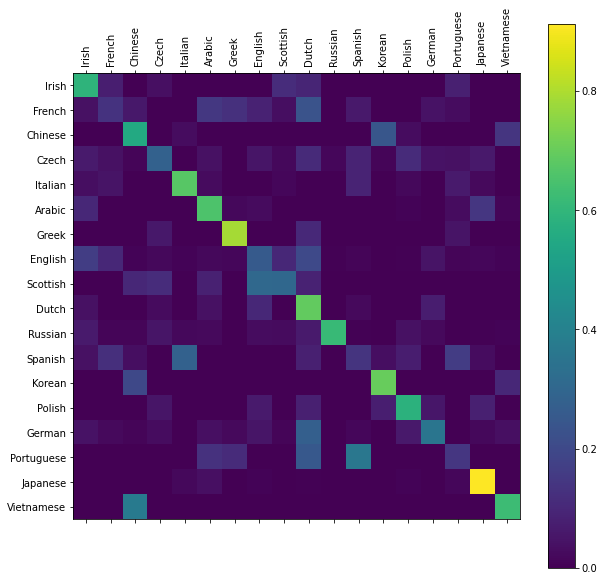

0.02 10000 0.1 0.916932225227356 Tselios Dutch Greek
0.02 20000 0.2 2.5369064807891846 Doljs Italian Czech
0.02 30000 0.3 0.6917365193367004 You Korean Korean
0.02 40000 0.4 1.9134279489517212 Pecora Arabic Italian
0.02 50000 0.5 0.06005607172846794 Missiakos Scottish Greek
0.02 60000 0.6 1.6665089130401611 Belrose French French
0.02 70000 0.7 0.6515316367149353 Dasios Russian Greek
0.02 80000 0.8 0.007377049885690212 Kubota Chinese Japanese
0.02 90000 0.9 1.7206764221191406 Taggart English English
0.02 100000 1.0 0.018068481236696243 Taylor Irish Scottish


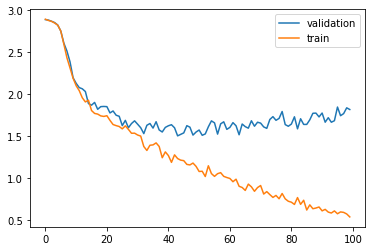

accuracy train:  0.8309


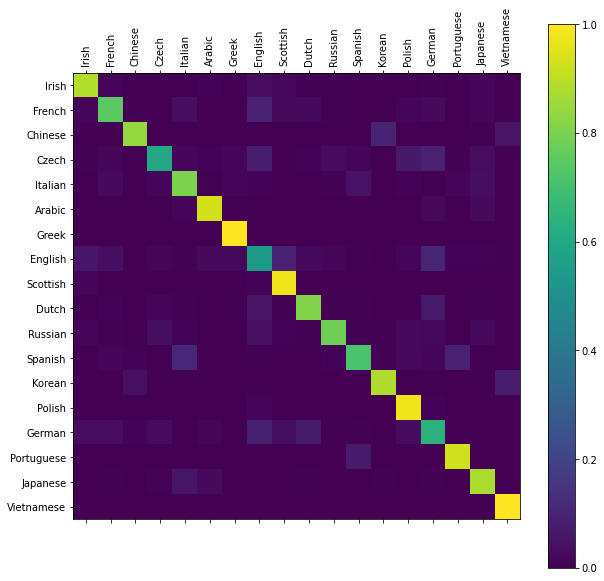

accuracy test:  0.5349


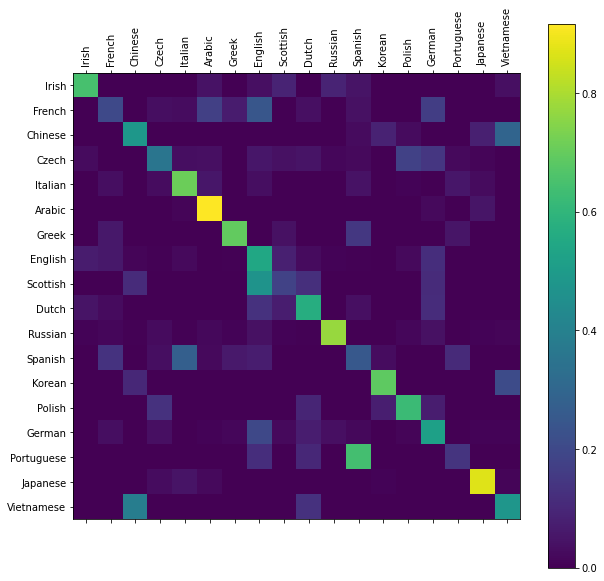

0.05 10000 0.1 0.342438280582428 Barbieri Vietnamese Italian
0.05 20000 0.2 1.068437933921814 Walker German Scottish
0.05 30000 0.3 0.4559367597103119 Heatley Greek English
0.05 40000 0.4 0.5916667580604553 Houlis Irish Greek
0.05 50000 0.5 2.054859161376953 Kober Italian Czech
0.05 60000 0.6 0.02317393198609352 Close Japanese Greek
0.05 70000 0.7 0.015904473140835762 Krivolavy Spanish Czech
0.05 80000 0.8 1.0530059337615967 Duarte French Portuguese
0.05 90000 0.9 0.547565758228302 Pittaluga Czech Italian
0.05 100000 1.0 0.11414015293121338 Dale Italian Dutch


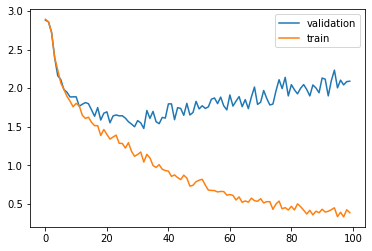

accuracy train:  0.8855


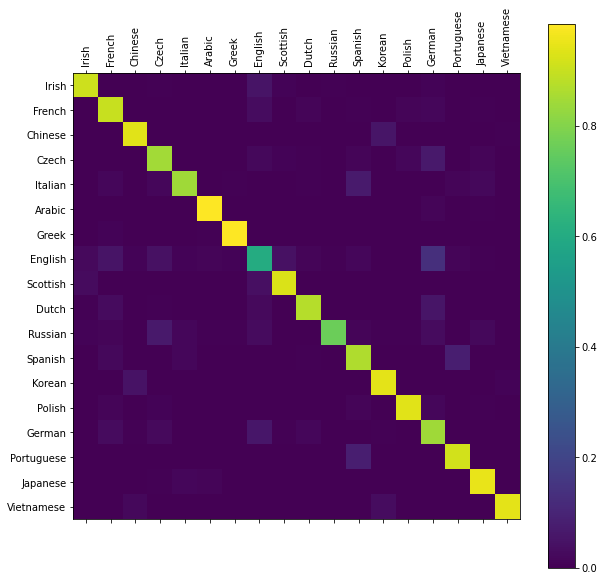

accuracy test:  0.4921


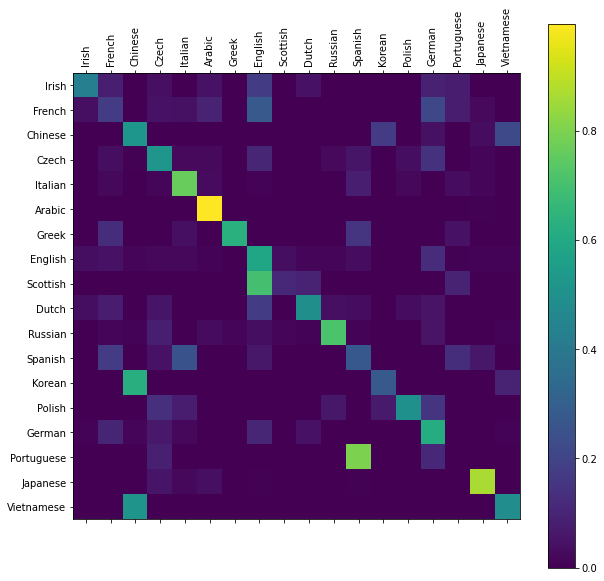

In [30]:
n_hidden = 128
learning_rates = [0.01, 0.02, 0.05]

for learning_rate in learning_rates:
  lstm = LSTM(n_letters, n_hidden, n_categories)

  n_iters = 100000
  print_every = 10000
  plot_every = 1000

  current_loss_train = 0
  all_losses_train = []
  current_loss_val = 0
  all_losses_val = []

  for iter in range(1, n_iters + 1):
    category_train, line_train, category_tensor_train, line_tensor_train = randomTrainingExample(train_data)
    output_train, loss_train = train_lstm(category_tensor_train, line_tensor_train, learning_rate)
    current_loss_train += loss_train

    category_val, line_val, category_tensor_val, line_tensor_val = randomTrainingExample(val_data)
    (hidden, cell) = lstm.init_hidden()
    for i in range(line_tensor_val.size()[0]):
      output, (hidden, cell) = lstm.forward(line_tensor_val[i], hidden, cell)
    loss_val = criterion(output.view(1, -1), category_tensor_val).item()
    current_loss_val += loss_val

    if iter % print_every == 0:
      guess, guess_i = category_from_output(output)
      print(learning_rate, iter, iter/n_iters, loss_train, line_train, guess, category_train)
  
    if iter % plot_every == 0:
      all_losses_train.append(current_loss_train/plot_every)
      current_loss_train = 0
      all_losses_val.append(current_loss_val/plot_every)
      current_loss_val = 0


  fig, ax = plt.subplots()
  ax.plot(all_losses_val, label='validation')
  ax.plot(all_losses_train, label='train')
  legend = ax.legend(loc='upper right')
  plt.show()
  
  confusion = torch.zeros(n_categories, n_categories)
  
  n_confusion = 10000
  
  pre = 0
  for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(train_data)
    output = evaluate_lstm(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    if category == guess:
        pre +=1
    confusion[category_i][guess_i] += 1
  
  print("accuracy train: ", pre/n_confusion)
  for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot()
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)
  
  ax.set_xticklabels([''] + all_categories, rotation=90)
  ax.set_yticklabels([''] + all_categories)
  
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()
  
  pre = 0
  for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample(test_data)
    output = evaluate_lstm(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    if category == guess:
        pre +=1
    confusion[category_i][guess_i] += 1
  
  print("accuracy test: ", pre/n_confusion)
  for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
  
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot()
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)
  
  ax.set_xticklabels([''] + all_categories, rotation=90)
  ax.set_yticklabels([''] + all_categories)
  
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()